In [223]:
# -*- coding: utf-8 -*-
# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime
import pickle

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pedophysics import predict, Soil
import FDEM
from FDEM import Initialize
from plots import *

from scipy import constants
from utils.spatial_utils import utm_to_epsg, get_coincident, get_stats_within_radius
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from PyPDF2 import PdfMerger

sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH
from emagpy import Problem
pd.set_option('display.max_columns', None)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
s_site = 'M'

# Parameters
extract = 0.5   # 0.5 2.5
# Inversion parameters
sample_loc = 'closest' # 'mean' or 'closest'
interface = 'observed' # log
FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
MinM = 'Gauss-Newton' # ROPE, Gauss-Newton, L-BFGS-B
alpha = 0.07
remove_coil = False
start_avg = False
constrain = True

In [225]:
# User input

only_samples = True

# Define input datatype and source folder
datafolder = 'data' # data folder
datafolder_ERT = 'data/ERT'
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

config = {}
config['FM'] = FM #'CS', 'FSlin' or 'FSeq'
config['MinM'] = MinM
                                        # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                        # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                        # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['alpha'] = alpha
config['remove_coil'] = remove_coil    # set to True if you want to remove coils in the inversion process
# Reference profile for starting model (conductivity values)
config['start_avg'] = start_avg     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model
config['constrain'] = constrain

# Sensor settings
config['instrument_code'] = 'Dualem-21HS' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation
config['regularization'] = 'l2'
reg_meth = config['regularization']

# Remove coils for inversion?
   
n = 4                             
if s_site == 'P':
    config['coil_n'] = [0, 1]    # indexes of coils to remove (cf. emagpy indexing)
                                # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                                # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

    config['reference_profile'] = 15 # ID of ERT (conductivity) profile to be used 
                                 #  to generate starting model
                                 # For proefhoeve nr 15 is used, for middelkerke 65

elif s_site == 'M':
    config['coil_n'] = [2, 3]    # indexes of coils to remove (cf. emagpy indexing)
                                # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                                # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

    config['reference_profile'] = 65 # ID of ERT (conductivity) profile to be used 
                                    #  to generate starting model
                                    # For proefhoeve nr 15 is used, for middelkerke 65

config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used

#if interface == 'observed' or interface == 'observed-fixed':
if interface == 'observed':
    config['interface'] = [0.3, 0.6, 1.0, 2.0 ] # depths to custom model interfaces

    #if site == 'M':
    #    config['bounds'] = [(5, 80), (50, 380), (76, 820), (100, 1000), (150, 1000)]
    #elif site == 'P':
    #    config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)] 

#elif interface == 'log-fixed' or interface == 'log':
elif interface == 'log':

    logint = np.geomspace(0.15, 2, num=7)
    logint[1:] += 0.15
    config['interface'] = logint.tolist()

    #if site == 'M':
    #    config['bounds'] = [(5, 80), (20, 300), (30, 380), (50, 350), (76, 600), (80, 700), (100, 1000), (130, 800)]
    #elif site == 'P':
    #    config['bounds'] = [(10, 55), (15, 100), (20, 160), (30, 200), (50, 335), (60, 300), (75, 500), (60, 500)] 


    # Define the interfaces depths between layers for starting model and inversion
    #           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used

# Inversion constraining
# if constrained inversion is used, you can set custom EC bounds (and other params)

config['custom_bounds'] = False
'''
    config['bounds'] is the 'bnds' used in emagpy constraining
    if you fix 2 interface and fit 3 layer EC:
    [(layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    If you fit 2 interfaces and fit 3 layer EC:
    [(int1_min, int1_max), 
    (int2_min, int2_max), 
    (layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    autobounds MDK:[(22.877321099166068, 83.29767890083818), 
    (50.6150000000018, 381.79940055200086), 
    (75.5445000000012, 819.2347232074701), 
    (124.346000000001, 1108.1655185859772), 
    (188.4700000000009, 1025.8167426267287)]   
'''
# !!! ---

# [  6.  43.]
#  [ 27. 183.]
#  [ 36. 307.]
#  [ 63. 335.]
#  [ 47. 337.]
#  [ 82. 224.]
#  [ 53. 103.]
#  [ 39.  73.]

if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# remove profiles at transect edges
config['n_omit'] =  10 # number of profiles to exclude from the start
                       # and end of the ERT transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available  

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    config['instrument_code'] == 'Dualem-21HS'
    emfile_prefix = 'proefhoeve_21HS'
    #else: 
    #    emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'
inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 
cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder_ERT, f'{profile_prefix}-inv-ERT-{extract}.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_raw_transect_calibrated_rECa_{extract}.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_raw_transect_calibrated_{extract}.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_calibrated_rECa_{extract}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samp_locations.csv')

if em_intype == 'rec':
    infile = em_rec
elif em_intype == 'survey':
    infile = em_survey
else:
    infile = em_lin

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph'
            ]

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)

if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

print('em_survey, samples:', em_survey, samples)
if sample_loc == 'closest':
    em_samples = get_coincident(em_survey, samples)
    #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{extract}_{sample_loc}.csv')
    #em_samples.to_csv(path_sample_loc)

elif sample_loc == 'mean':
    if s_site == 'P':
        em_samples = get_stats_within_radius(em_survey, samples, 1)
        #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{extract}_{sample_loc}.csv')
        #em_samples.to_csv(path_sample_loc)

    elif s_site == 'M':
        em_samples = get_stats_within_radius(em_survey, samples, 2)
        #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{extract}_{sample_loc}.csv')
        #em_samples.to_csv(path_sample_loc)

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

if config['n_omit'] == 0:
    ert_final = ert_p.copy()
else:
    if config['n_omit']*2 >= len(unique_ids):
        warnings.warn('!!! You removed all profiles !!! Change value for config[n_omit]')
        raise KeyboardInterrupt
    else:
        selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
        ert_p = ert_p.loc[ert_p['ID'].isin(selected_ids)]
        ert_final = ert_p.copy()

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final.loc[:, dataset_name] = ert_final[dataset_name]*1000
dc_corr.loc[:,dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'Z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest
# #Plotting combined profiles
# plot_combined_profiles(ert_final, all_profiles_df, 
#                        data_column, compare_name = data_column)
#

em_survey, samples:                  x            y         z         t      HCP1QP      PRP1QP  \
0      41563.15402  204149.1651  0.358554  45474.80  189.167023   89.069323   
1      41563.15309  204149.1669  0.358554  45475.00  189.167023   89.069323   
2      41563.15194  204149.1691  0.358554  45475.17  189.167023   89.069323   
3      41563.15023  204149.1724  0.358554  45475.38  189.167023   89.069323   
4      41563.14844  204149.1758  0.358554  45475.58  189.167023   89.069323   
...            ...          ...       ...       ...         ...         ...   
30149  41737.92416  204225.0505  0.350000  54617.16  270.186158  199.496872   
30150  41737.91989  204225.0517  0.350000  54617.36  270.186158  199.496872   
30151  41737.91694  204225.0526  0.350000  54617.57  270.186158  199.496872   
30152  41737.91599  204225.0529  0.350000  54617.77  270.186158  199.496872   
30153  41737.91598  204225.0529  0.350000  54629.55  270.186158  199.496872   

           HCP2QP     PRP2QP   

<Figure size 1000x800 with 0 Axes>

merged_df        Z    easting    northing  EC(mS/m)     ID
0   -2.3  41667.009  204315.397  197.0230   11.0
1   -2.0  41667.009  204315.397  133.3235   11.0
2   -1.0  41667.009  204315.397   73.2775   11.0
3   -0.6  41667.009  204315.397   53.4300   11.0
4   -0.3  41667.009  204315.397   47.5855   11.0
..   ...        ...         ...       ...    ...
495 -2.3  41685.993  204269.682  588.5200  110.0
496 -2.0  41685.993  204269.682  520.9205  110.0
497 -1.0  41685.993  204269.682  320.5000  110.0
498 -0.6  41685.993  204269.682  172.0610  110.0
499 -0.3  41685.993  204269.682   76.9910  110.0

[500 rows x 5 columns]
models {11.0: <FDEM.Initialize.Model object at 0x000001DDB492E790>, 12.0: <FDEM.Initialize.Model object at 0x000001DDB492E810>, 13.0: <FDEM.Initialize.Model object at 0x000001DDB492E750>, 14.0: <FDEM.Initialize.Model object at 0x000001DDB492F150>, 15.0: <FDEM.Initialize.Model object at 0x000001DDB492D810>, 16.0: <FDEM.Initialize.Model object at 0x000001DDB492E250>, 17.0: <FDE

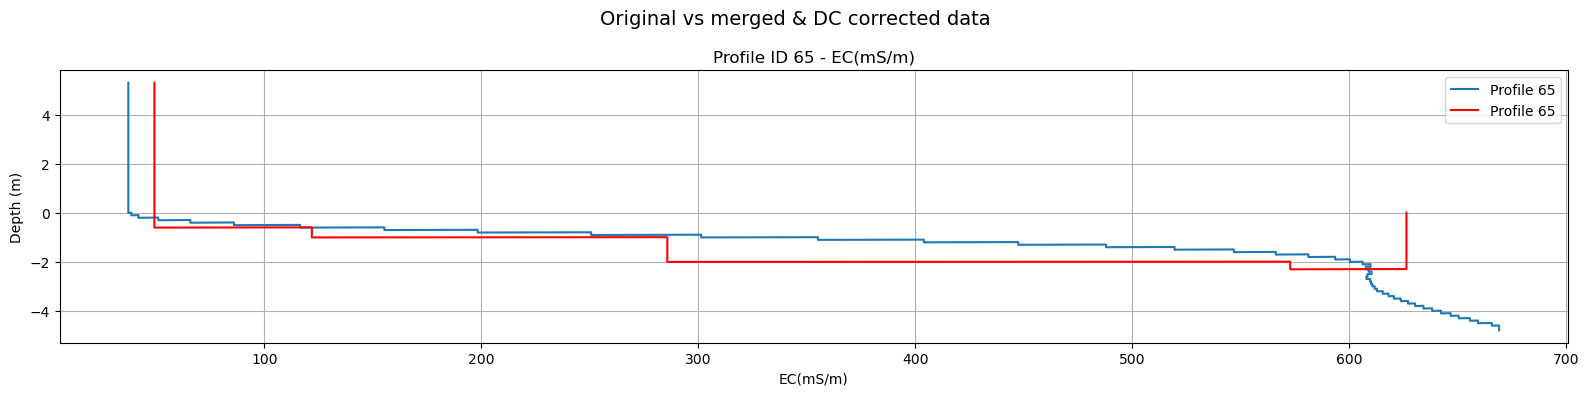

In [226]:
# config['reference_profile'] = 11
pd.set_option('display.max_columns', None)

if config['reference_profile'] not in all_profiles_df['ID'].unique():
    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
    raise KeyboardInterrupt
else:
    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
    
else:
    merged_df = all_profiles_df
comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
ert_eval = ert_final.copy()
ert_eval['Z'] = ert_eval['Z'].values + first_in

plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

print('merged_df', merged_df)
models = generate_forward_model_inputs(merged_df, 'ID', 'Z', 'EC(mS/m)')
print('models', models)


merged_df        Z    easting    northing  EC(mS/m)     ID
0   -2.3  41667.009  204315.397  197.0230   11.0
1   -2.0  41667.009  204315.397  133.3235   11.0
2   -1.0  41667.009  204315.397   73.2775   11.0
3   -0.6  41667.009  204315.397   53.4300   11.0
4   -0.3  41667.009  204315.397   47.5855   11.0
..   ...        ...         ...       ...    ...
495 -2.3  41685.993  204269.682  588.5200  110.0
496 -2.0  41685.993  204269.682  520.9205  110.0
497 -1.0  41685.993  204269.682  320.5000  110.0
498 -0.6  41685.993  204269.682  172.0610  110.0
499 -0.3  41685.993  204269.682   76.9910  110.0

[500 rows x 5 columns]
profile_data        Z    easting    northing  EC(mS/m)    ID
270 -2.3  41677.364  204290.461   626.252  65.0
271 -2.0  41677.364  204290.461   572.673  65.0
272 -1.0  41677.364  204290.461   285.646  65.0
273 -0.6  41677.364  204290.461   121.829  65.0
274 -0.3  41677.364  204290.461    49.273  65.0
con [0.626252 0.572673 0.285646 0.121829 0.049273]
profile_data         Z    

C:\Users\mendo\AppData\Local\Temp\ipykernel_4892\814609592.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])


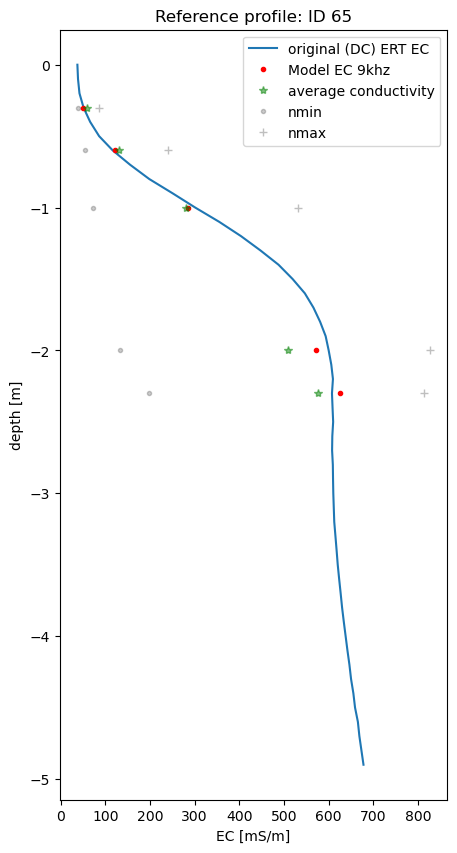

In [227]:
# 
# -------------------------------------------------------------------- #

# 
print('merged_df', merged_df)
profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'Z'
max_ert_depth = ert_final['Z'].abs().max()

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

if not config['n_int']:
    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
    if first_lay == 0:
        profile_data[depth]=profile_data[depth] +second_lay
    else:
        profile_data[depth]=profile_data[depth] +first_lay
    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
else:
    thick = -profile_data[depth].values

print('profile_data', profile_data)
con = profile_data[res_col].values/1000
print('con', con)

ref_len = len(con)
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]
print('profile_data', profile_data)

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
axr.plot((profile_data[dataset_name]),profile_data['Z'], label='original (DC) ERT EC',)
if not config['n_int']: 
    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
else:
    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
axr.set_title(f'Reference profile: ID {profile_id}')

conductivities = con*1000
print('conductivities', conductivities, len(conductivities))

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
    mod_layers = thick[1:]
else:
    if len(conductivities) == len(thick):
        mod_layers = thick[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(thick)+1):
        mod_layers = thick
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    else:
        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
for i in merged_df['ID'].unique(): 
    profile_data = merged_df[merged_df['ID'] == i].copy()
    
    if not config['n_int']:
        if abs(profile_data.iloc[0]['Z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[0].name)
        elif abs(profile_data.iloc[-1]['Z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[-1].name)
    res_col = 'EC(mS/m)'
    depth = 'Z' 
    con_m = profile_data[res_col].values
    layers_interfaces = np.cumsum(models[i].thick)
    layers_interfaces = np.insert(layers_interfaces, 0, 0)
    num_layers = len(con)
    perm = np.full(num_layers, constants.epsilon_0)
    sus = np.zeros(num_layers)

    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

    if not config['n_int']:
        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
        if first_lay == 0:
            profile_data[depth]=profile_data[depth] +second_lay
        else:
            profile_data[depth]=profile_data[depth] +first_lay
        thick = -profile_data[depth].iloc[1:].values
    else:
        thick = -profile_data[depth].values

    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

    # if a == 1:
    #     fig, ax = plt.subplots(figsize=(5, 10))
    #     ax.set_xlabel('EC [mS/m]')
    #     ax.set_ylabel('depth [m]')
    #     profile_data = ert_final[ert_final['ID'] == i]
    #     ax.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
    #     if not config['n_int']:
    #         ax.plot(con[:-1],-thick, '.', label='Model EC 9khz',color = 'red')
    #     else:
    #         ax.plot(con,-thick, '.', label='Model EC 9khz',color = 'red')
    #     ax.set_title(f'profile {i}')
    #     ax.legend()
    #     a = a +1

ec_df.reset_index(drop=True, inplace=True)

ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
ec_stats.rename(index={'50%': 'median'}, inplace=True)
ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #
print('ec_stats', ec_stats)
if not config['n_int']:
    minstat = np.flipud(ec_stats.loc['min'].values[1:])
    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
    start_mod = ec_stats.loc['mean'].values[1:]
    boundcols = ec_cols_ref[:-1]
else:
    minstat = np.flipud(ec_stats.loc['min'].values)
    maxstat = np.flipud(ec_stats.loc['max'].values)
    start_mod = ec_stats.loc['mean'].values

axr.plot(np.flipud(start_mod),position, 
            '*', 
            label='average conductivity',
            color = 'green',
            alpha = 0.5)
axr.plot(minstat,position, 
            '.', 
            label='nmin',
            color = 'black',
            alpha = 0.2)
axr.plot(maxstat,position, 
            '+', 
            label='nmax',
            color = 'black',
            alpha = 0.25)

axr.legend()

if config['constrain']:
    #if config['custom_bounds']:
    #    bounds = config['bounds']
    #else:
        bounds = []
        for i, name in enumerate(ec_cols_ref):
            if ec_stats.loc['min_sd'][name] > 0:
                nmin = ec_stats.loc['min_sd'][name]
            elif ec_stats.loc['min'][name] > 0:
                nmin = ec_stats.loc['min'][name]
            else:
                nmin = 1
            nmax = ec_stats.loc['max_sd'][name]
            min_max = tuple([nmin,nmax])
            bounds.append(min_max)
        bounds = np.round(bounds, decimals=0)
    #    if not config['n_int'] and not config['custom_bounds']:
    #        bounds = bounds[1:]
        print(f'autobounds = {bounds}')



conductivities [626.252 572.673 285.646 121.829  49.273]
np.flipud(mod_layers) [0.3 0.6 1.  2. ]
np.flipud(conductivities) [ 49.273 121.829 285.646 572.673 626.252]
[]
[]
Data used for inversion: ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165']
lengths: mod_layers = 4; bounds =  5; con = 5


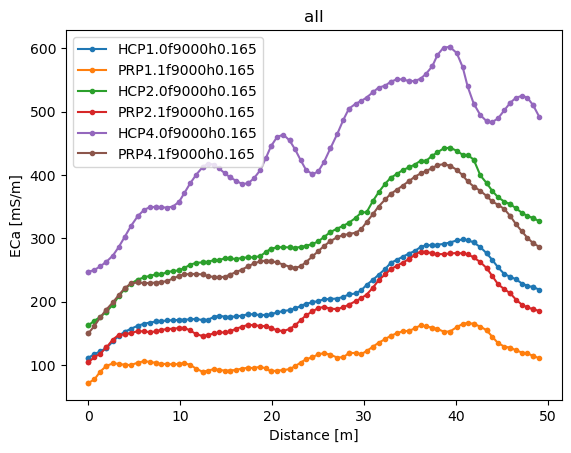

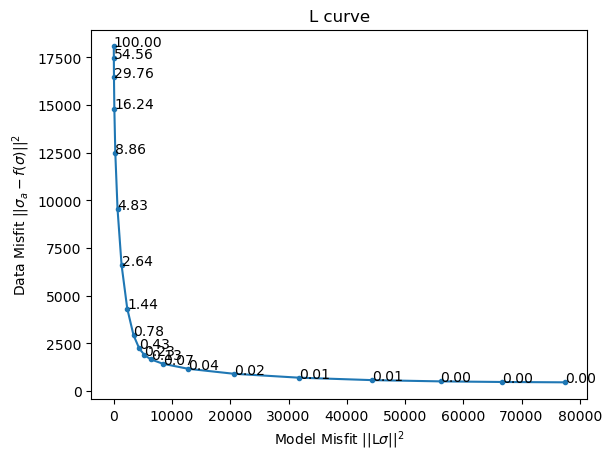

In [228]:
# FDEM inversion along ERT transect
# --------------------------------

if em_intype == 'rec':
    em_input = em_rec.copy()
elif em_intype == 'survey':
    em_input = em_survey.copy()
else:
    em_input = em_lin.copy()
print('conductivities', conductivities)

if config['start_avg']:
    print('start_mod', start_mod)
    
    conductivities = start_mod
    if len(conductivities) == len(mod_layers):
        mod_layers = mod_layers[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(mod_layers)+1):
        mod_layers = mod_layers
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")

if 'p_ID' in em_input.columns:
    em_input = em_input.rename(columns={"p_ID": "ID"})

temp_dir = 'temp_emp' 
infile_name = 'survey_input.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
em_input.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_input.columns.values[n:n+i] = new_columns

em_input.to_csv(temp_file)

# transect inversion settings
t_rec = Problem()
t_rec.createSurvey(temp_file)

print('np.flipud(mod_layers)', np.flipud(mod_layers))
print('np.flipud(conductivities)', np.flipud(conductivities))
print(t_rec.forward(forwardModel=FM))


if interface == 'observed' or interface == 'log':
    t_rec.setInit(
        depths0=np.flipud(mod_layers),
        conds0=np.flipud(conductivities),
        #fixedDepths=len(np.flipud(mod_layers))*[False],
        #fixedConds= len(np.flipud(conductivities))*[False]
        )
    
print(t_rec.forward(forwardModel=FM))

#elif interface == 'observed' or interface == 'log':
    
##    t_rec.setInit(
##        depths0=np.flipud(mod_layers),
#        conds0=np.flipud(conductivities),
#        fixedDepths=len(np.flipud(mod_layers))*[False],
#        fixedConds= len(np.flipud(conductivities))*[False]
#        )

shutil.rmtree(temp_dir)

if config['remove_coil']:
    
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = t_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            t_rec.removeCoil(config['coil_n'][i[0]]-i[0])

    else:
        t_rec.removeCoil(config['coil_n'])
print(f'Data used for inversion: {t_rec.coils}')
t_rec.show()


# alphas = np.logspace(n,m,n_alph)
t_rec.lcurve()
if config['constrain']:
    print(f'lengths: mod_layers = {len(mod_layers)}; bounds =  {len(bounds)}; con = {len(conductivities)}')
else:
    print(f'lengths: mod_layers = {len(mod_layers)}; con = {len(conductivities)}')


In [229]:
if not only_samples:
    # invert using ROPE solver (RObust Parameter Estimation)
    warnings.filterwarnings('ignore')

    if MinM in ['MCMC', 'ROPE']:
        if config['constrain']:
            print(f'Constrained inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
            t_rec.invert(forwardModel = FM, method=MinM, 
                    regularization=reg_meth, alpha=alpha, njobs=-1,
                    bnds=bounds
                    )
        else:
            print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
            t_rec.invert(forwardModel=FM, method=MinM, 
            regularization=reg_meth, alpha=alpha, njobs=-1
            )

    else:
        if config['constrain']:

            print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
            t_rec.invert(forwardModel=FM, method=MinM, alpha=alpha,regularization=reg_meth,
                        bnds=bounds)
            
        else : 
            t_rec.invert(forwardModel=FM, method=MinM, alpha=alpha, regularization=reg_meth)

    print(t_rec.forward(forwardModel=FM))

    t_rec.showOne2one()

In [230]:
if not only_samples:
    # 4.1: Plot the inversion results and put outcomes into a pandas dataframe
    # ------------------------------------------------------------------------
    csv_filename = f'{emfile_prefix}_inverted_transect_{sample_loc}_{extract}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'

    # ******************************************************************** #

    # Plot inversion outcomes down to a max depth of 2 m, and plotting the data
    # based on their true coordinates along the transect (dist=True).
    t_rec.showResults(dist=True, errorbar = True) 
    
    print('t_rec.depths[0][0]', t_rec.depths[0][0])

    # Extracting the values from the first row of the transect.depths[0] array
    depth_values = t_rec.depths[0][0]

    # Creating the custom column names for layer_cols
    layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

    # Combining the data from the 'x', 'y' columns and the transect.models[0] array
    data = np.c_[t_rec.surveys[0].df[['x', 'y']].values, t_rec.models[0]]

    # Creating the final dataframe with the desired column names
    dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
    dt_inv['pos'] = em_input['ID']
    # ----------------------------------------------------------------------

    # Export the dataframe as a csv-file
    outfile_transect = os.path.join(inv_folder, csv_filename)
    dt_inv.to_csv(outfile_transect)

In [231]:
%autoreload

if not only_samples:
    # Function to extract depth from column name
    def extract_depth(col_name):
        if col_name.startswith('EC_'):
            return float(col_name.split('_')[1])
        return None

    # Extracting depth values and sorting them
    depth_cols = [col for col in dt_inv.columns if col.startswith('EC_')]
    depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
    depths.sort()

    # Calculate depth for 'EC_end'
    if depths:
        end_depth = depths[-1] + depths[0]
        depths.append(end_depth)

    # Creating the new DataFrame
    transformed_data = {
        'Z': [],
        'EC': [],
        'easting': [],
        'northing': [],
        'ID': []
    }

    # Populating the new DataFrame
    for _, row in dt_inv.iterrows():
        for depth, depth_col in zip(depths, depth_cols):
            transformed_data['Z'].append(-depth)
            transformed_data['EC'].append(row[depth_col])
            transformed_data['easting'].append(row['x'])
            transformed_data['northing'].append(row['y'])
            transformed_data['ID'].append(row['pos'])

    transformed_df = pd.DataFrame(transformed_data)

    pdf_files = []
    if s_site == 'P':
        xlims = (0, 400)
    elif s_site == 'M':
        xlims = (0, 800)

    for i in transformed_df['ID'].unique():
        profile_label = str(i)
        if '.0' in profile_label:
            profile_label = profile_label.split('.')[0]
        filename = plot_profile(dc_corr, i, dataset_name,
                    compare=True, compare_df = transformed_df, compare_name = 'EC',
                    xlims=xlims,
                    ylims=(-2, 0),
                    block=True,
                    save_plot = True, 
                    plot_name = f'{FM}_inversion_p{profile_label}'
                    )
        
        pdf_files.append(filename)

    # Merge and save PDFs
    merger = PdfMerger()
    for pdf in pdf_files:
        merger.append(pdf)
    merged_pdf_filename = f'{emfile_prefix}_inverted_transects_{extract}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.pdf'
    outfile_transect_pdf = os.path.join(inv_folder, merged_pdf_filename)
    merger.write(outfile_transect_pdf)
    merger.close()
    for pdf in pdf_files:
        os.remove(pdf)
    clear_output(wait=False)

In [232]:
# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

# if config['n_omit'] != 0:
#     unique_ids = em_input['ID'].unique()
#     print(unique_ids)
#     selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
#     em_input = em_input.loc[em_input['ID'].isin(selected_ids)]

infile_name = 'infile_s02.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)

# transect inversion settings

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

print('np.flipud(mod_layers)', np.flipud(mod_layers))
print('conductivities', conductivities)

print(s_rec.forward(forwardModel=FM))


if interface == 'observed' or interface == 'log':
    print('setInit')
    s_rec.setInit(
        depths0=np.flipud(mod_layers),
        conds0=conductivities,
        )
    
print(s_rec.forward(forwardModel=FM))

#elif interface == 'observed' or interface == 'log':
#    s_rec.setInit(
#        depths0=np.flipud(mod_layers),
#        conds0=conductivities,
#        fixedDepths=len(np.flipud(mod_layers))*[False],
#        fixedConds= len(conductivities)*[False]
#        )    

#shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        s_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {s_rec.coils}')


np.flipud(mod_layers) [0.3 0.6 1.  2. ]
conductivities [626.252 572.673 285.646 121.829  49.273]
[]
setInit
[]
Data used for inversion: ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165']


In [233]:
# Pickling the dictionary
#with open('s_rec.pkl', 'wb') as file:
#    pickle.dump(s_rec, file)

Constrained Inversion using FSeq with Gauss-Newton, reg=l2, alpha=0.07
15/15 inverted['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165']
[    HCP1.0f9000h0.165  PRP1.1f9000h0.165  HCP2.0f9000h0.165  \
0          163.903918          69.716644         248.045233   
1          148.425965          97.227020         180.698594   
2          205.894804          98.948136         294.781395   
3          201.965139          97.622705         288.152015   
4          230.207139         152.637820         274.923166   
5          184.298815          92.867420         256.092563   
6          131.378899          45.995752         212.047454   
7          177.205294         115.371204         216.176797   
8          143.828906          67.465122         209.400769   
9          238.540975         128.741833         320.446699   
10         216.354837         148.731069         251.296016   
11         112.975285          

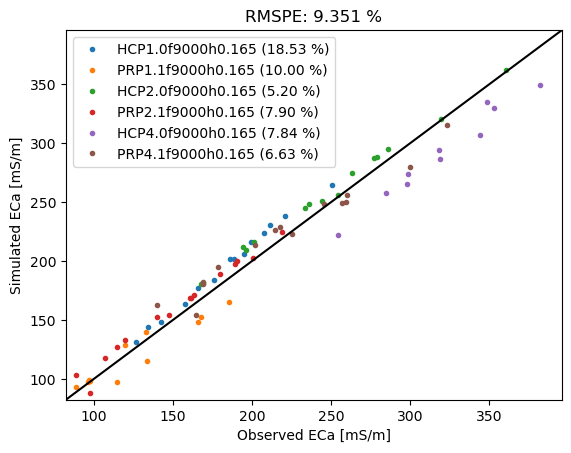

In [234]:
alpha = 0.07

if MinM in ['MCMC', 'ROPE']:
    if config['constrain']:
        print(f'Constrained inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel='FSlin', method='ROPE', 
                        regularization=reg_meth, alpha=alpha, njobs=1) # Not all options are for all solvers
    else:
        print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel=FM, method=MinM, 
                        regularization=reg_meth, alpha=alpha, njobs=1, options={'maxiter': 100, 'disp': True})
        
else:
    if config['constrain']:
        print(f'Constrained Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel=FM, method=MinM, alpha=alpha, regularization=reg_meth, bnds=bounds)
    else: 
        print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel=FM, method=MinM, alpha=alpha, regularization=reg_meth)
        
print(s_rec.coils)
print(s_rec.forward(forwardModel=FM))
s_rec.showOne2one()

In [235]:
survey = s_rec.surveys[0]
dfsForward = s_rec.forward(forwardModel=FM)[0]
r2 = pd.DataFrame(columns=np.r_[s_rec.coils, ['all']])

print('r2', r2)
print(s_rec.coils)
i =0

def r2_inv(survey, dfsForward, r2):

    for coil in s_rec.coils:
        print('coil', coil)
        obsECa = survey.df[coil].values
        print('obsECa', obsECa)

        simECa = dfsForward[coil].values
        print('simECa', simECa)

        r2.loc[i, coil] = r2_score(simECa, obsECa)
    obsECa = survey.df[s_rec.coils].values.flatten()
    simECa = dfsForward[s_rec.coils].values.flatten()
    r2.loc[i, 'all'] = r2_score(simECa, obsECa)
    return r2

r2_inv(survey, dfsForward, r2)['all']

r2 Empty DataFrame
Columns: [HCP1.0f9000h0.165, PRP1.1f9000h0.165, HCP2.0f9000h0.165, PRP2.1f9000h0.165, HCP4.0f9000h0.165, PRP4.1f9000h0.165, all]
Index: []
['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165']
coil HCP1.0f9000h0.165
obsECa [157.37911649 142.72664059 195.05796588 186.22669515 211.14240655
 176.14574457 126.55935477 166.10629383 134.44819364 220.98926353
 199.48511023  67.52526634 250.74383513 188.61544964 207.80645752]
simECa [163.90391769 148.4259647  205.89480447 201.96513945 230.20713899
 184.29881548 131.37889878 177.20529396 143.82890623 238.54097492
 216.35483742 112.97528479 264.38561126 201.99710912 223.96917651]
coil PRP1.1f9000h0.165
obsECa [ 76.45950991 114.87159109  97.19943196  96.35824878 167.97149594
  89.06932274  53.50005941 133.96193385  77.01979412 119.92333986
 165.72135316  46.50497852 133.11937135  97.76023835 185.69915477]
simECa [ 69.7166435   97.22702025  98.94813601  97.

0    0.968624
Name: all, dtype: object

s_rec [0.3 0.6 1.  2. ]
em_samples                  x            y         z         t  HCP1.0f9000h0.165  \
5707   41564.53508  204206.6350  0.550000  46700.42         157.379116   
11480  41548.70351  204311.6093  0.849275  48080.26         142.726641   
6927   41589.68646  204167.8156  0.550000  46944.42         195.057966   
25046  41668.92012  204238.2888  0.450000  53527.92         186.226695   
8518   41521.64592  204334.5815  0.850000  47262.62         211.142407   
19201  41617.05436  204259.0171  0.614979  51612.30         176.145745   
13168  41576.95294  204271.2311  1.150000  48437.26         126.559355   
12607  41533.54743  204357.0333  0.650000  48325.06         166.106294   
25333  41642.94946  204299.0550  0.650000  53586.61         134.448194   
28024  41701.02230  204261.7069  0.050000  54124.14         220.989264   
3251   41513.61527  204286.1329  0.158554  46209.19         199.485110   
22376  41619.48192  204273.3088  0.650000  52247.32          67.525266   
264

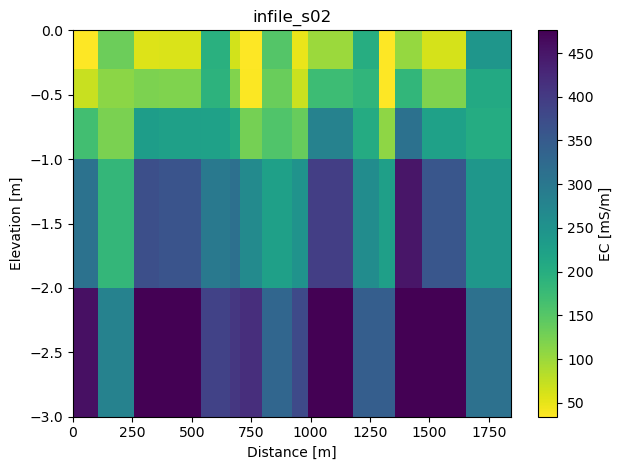

In [236]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{emfile_prefix}_inverted_samples_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 
print('s_rec', s_rec.depths[0][0])

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
print('em_samples', em_samples)
print('ds_inv', ds_inv)

ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_invsampl = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_invsampl)

             x            y     EC_0.30     EC_0.60     EC_1.00     EC_2.00  \
0  41564.53508  204206.6350   28.906097   71.880624  167.967275  309.082099   
1  41548.70351  204311.6093  132.640703  111.410142  123.714826  183.911193   
2  41589.68646  204167.8156   58.160651  121.236844  231.768627  369.817695   
3  41668.92012  204238.2888   59.054476  119.277065  227.011376  361.111559   
4  41521.64592  204334.5815  196.263862  191.358098  224.635639  297.899643   

       EC_end   pos  
0  457.559435  2001  
1  281.098158  2002  
2  492.936514  2003  
3  478.118175  2004  
4  388.347866  2005  


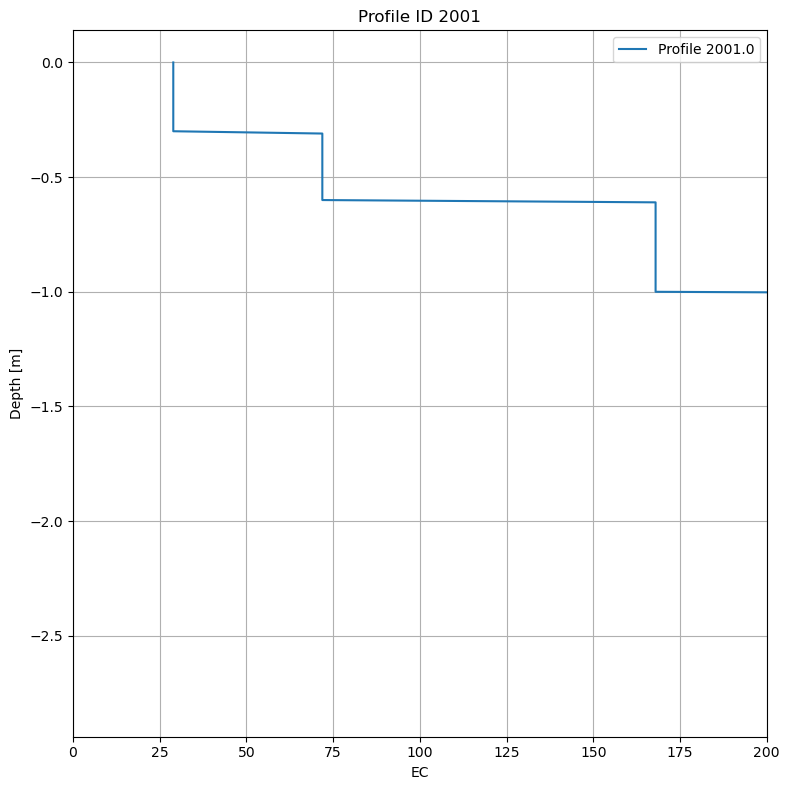

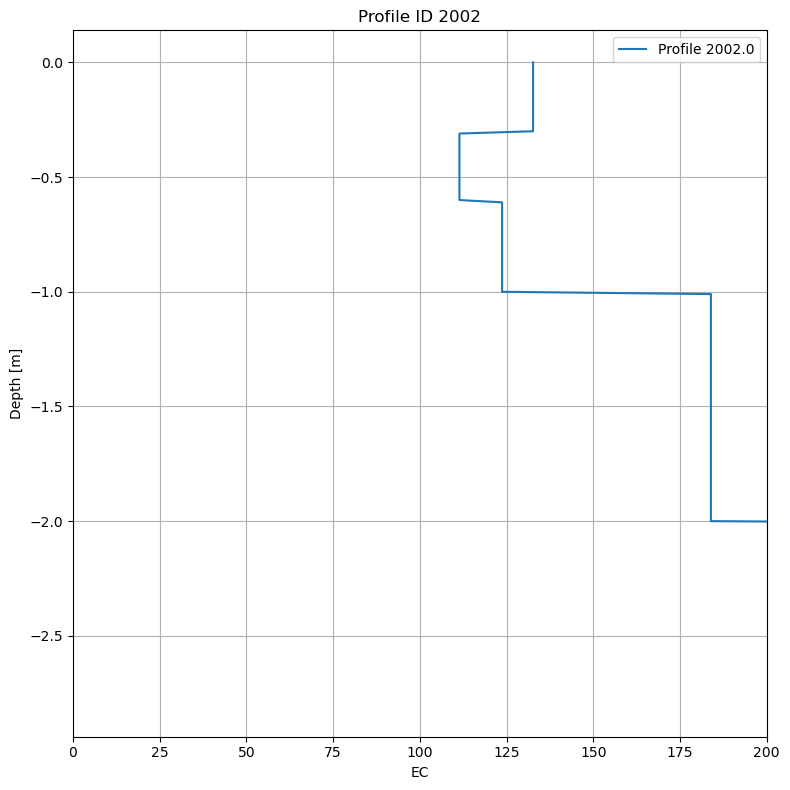

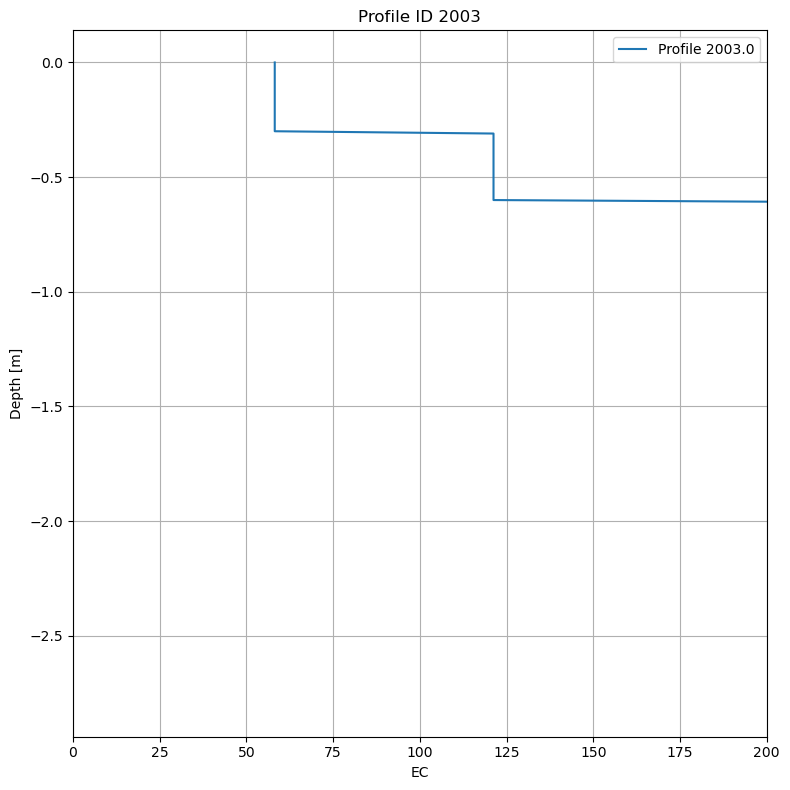

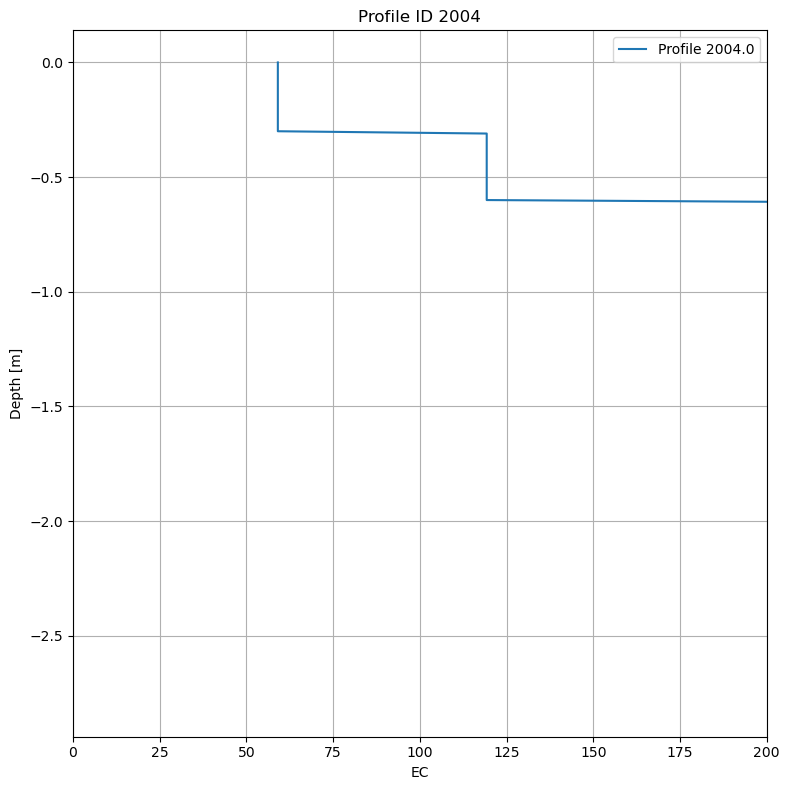

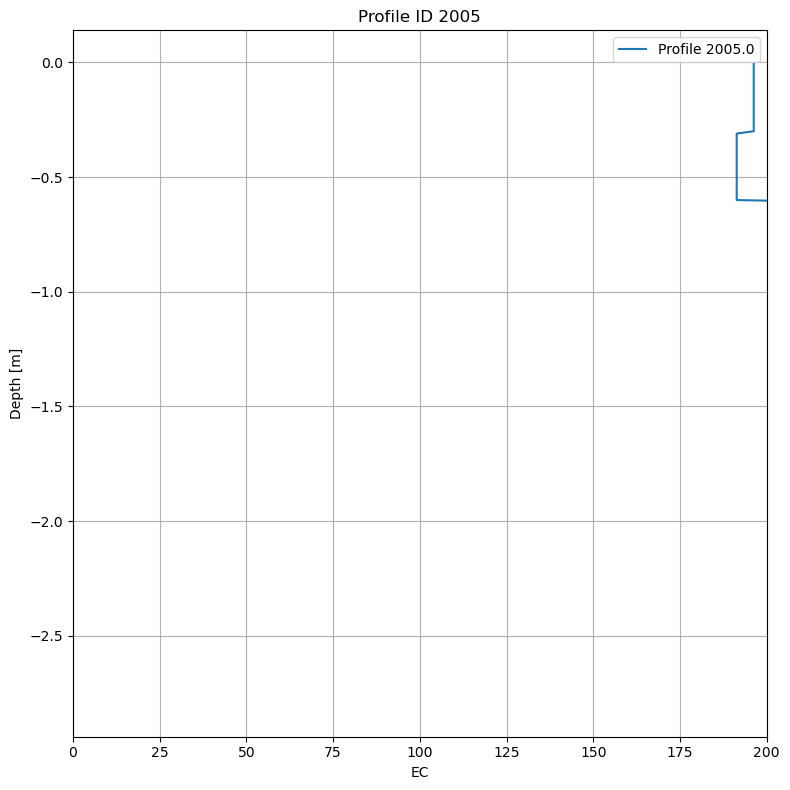

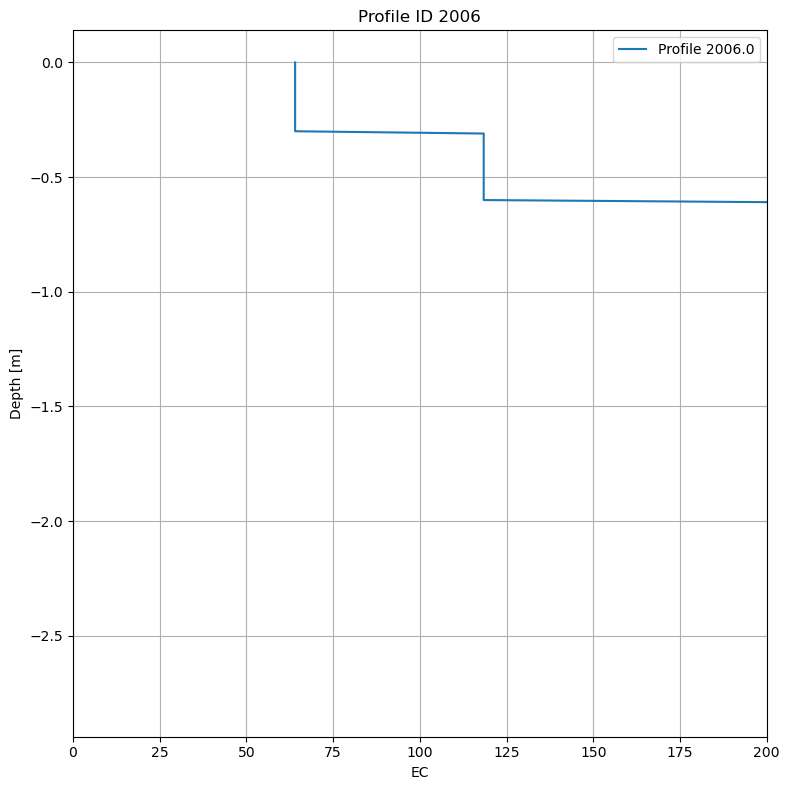

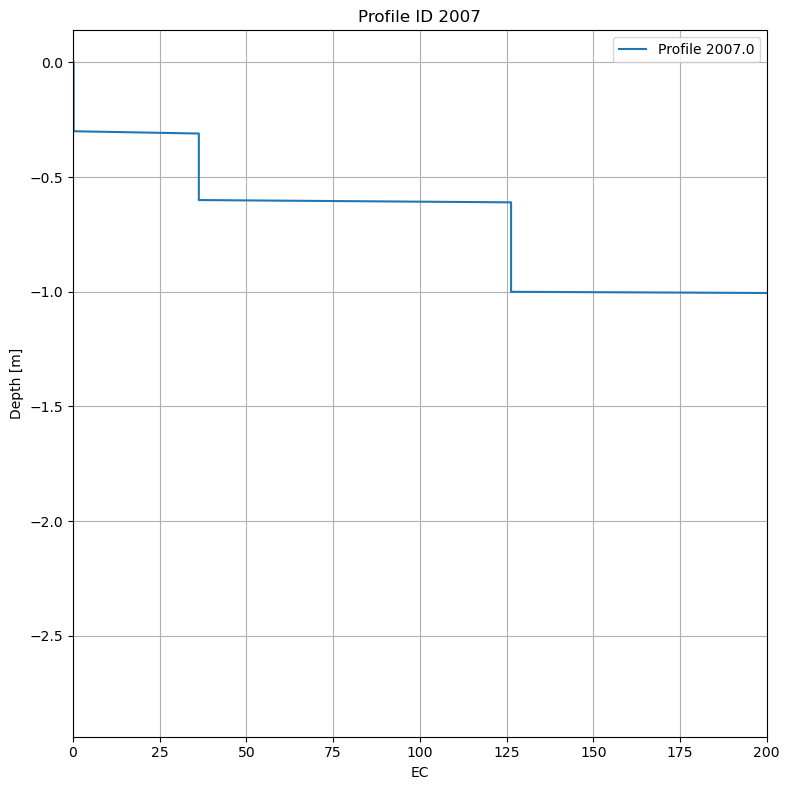

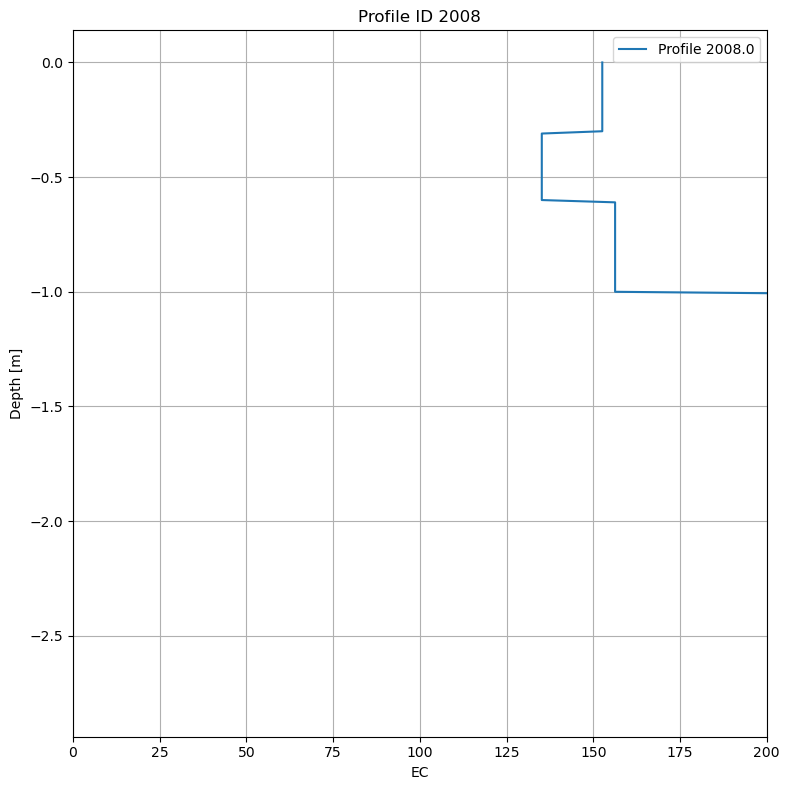

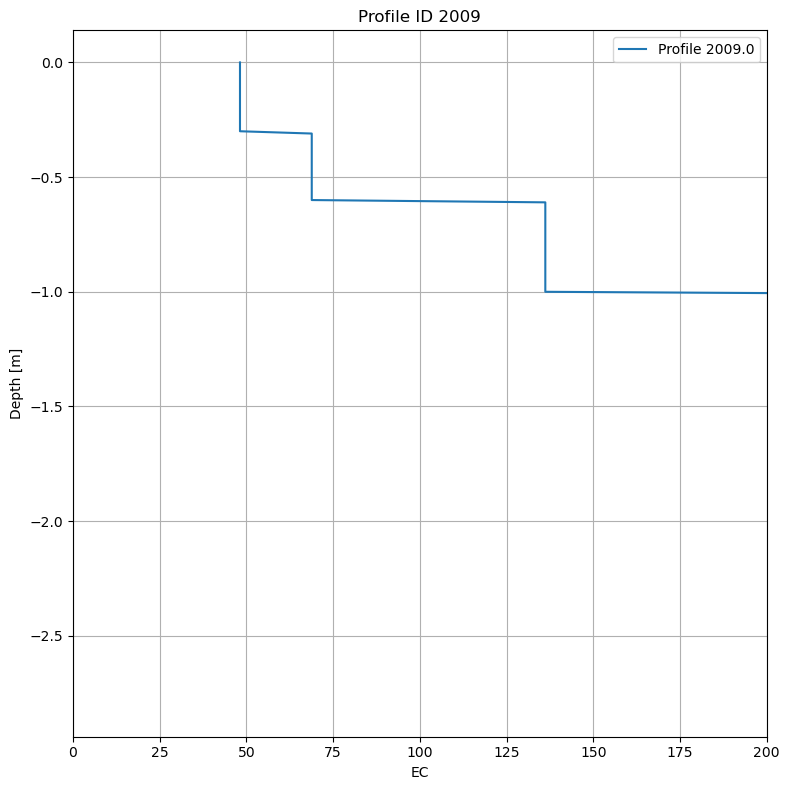

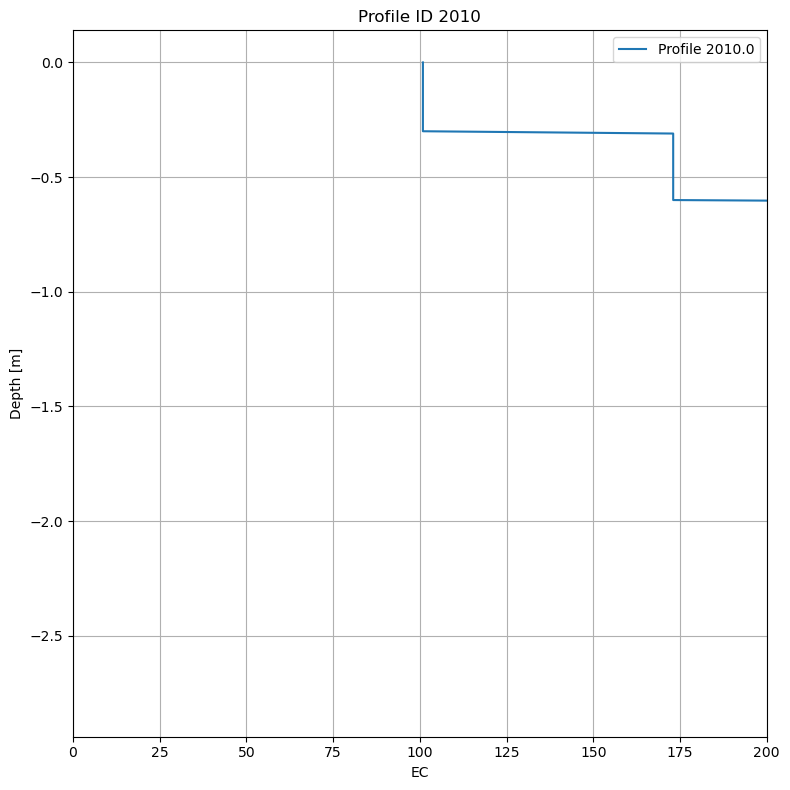

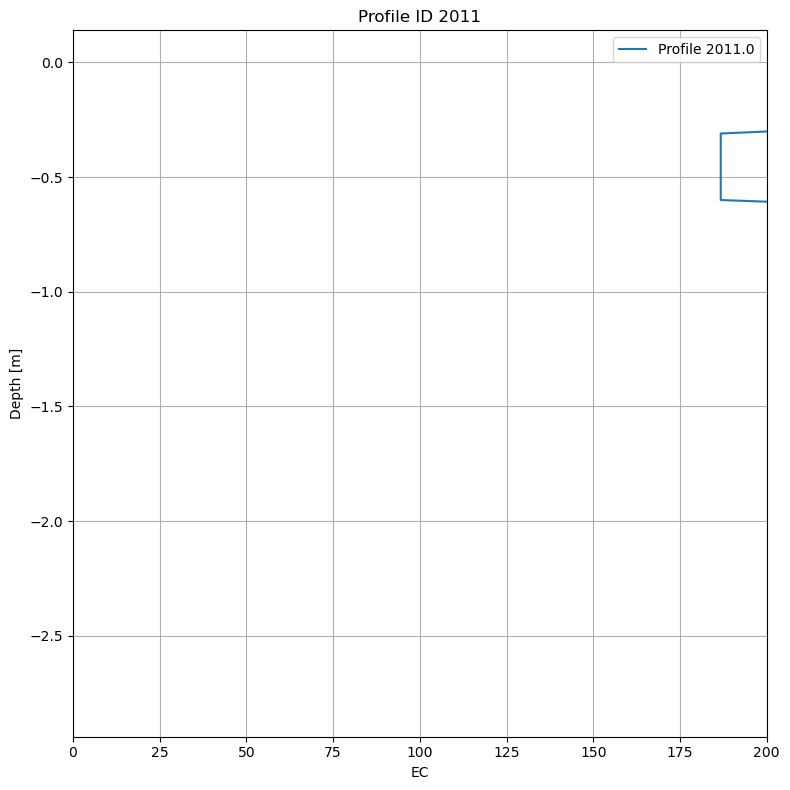

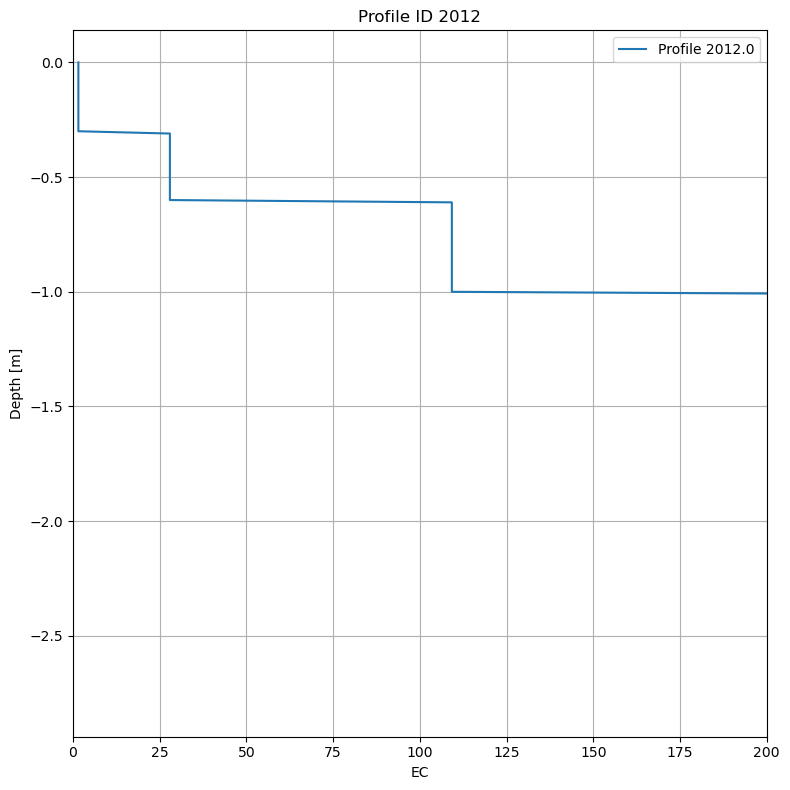

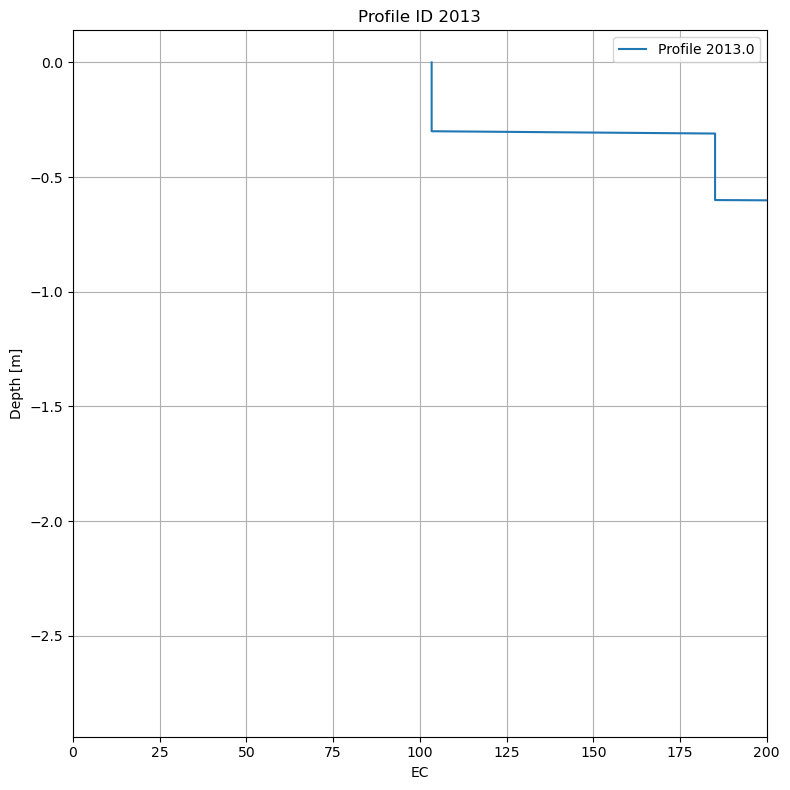

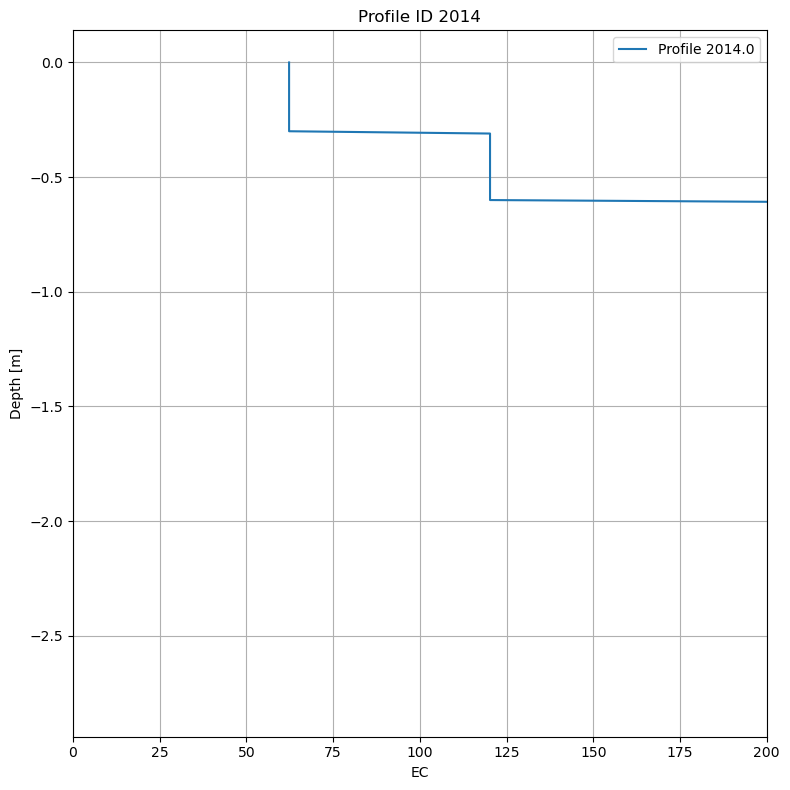

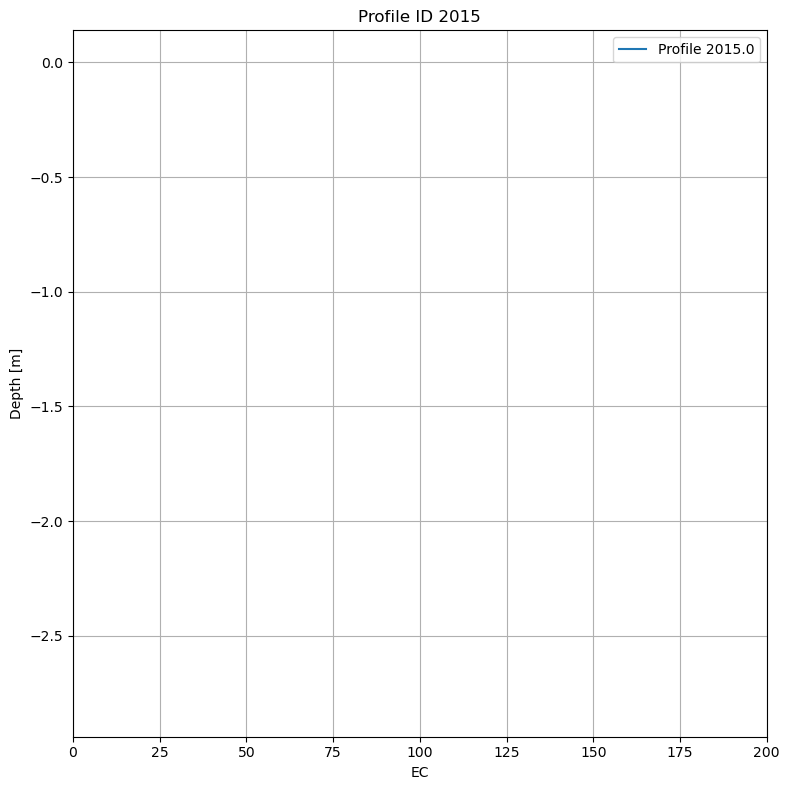

In [237]:
%autoreload
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in ds_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'Z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in ds_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['Z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

pdf_files = []
for i in transformed_df['ID'].unique():
    profile_label = str(i)
    if '.0' in profile_label:
        profile_label = profile_label.split('.')[0]
    filename = plot_profile(transformed_df, i, 'EC', xlims=(0,200),
                 block=True,
                 save_plot = True, 
                 plot_name = f'{FM}_inversion_p{profile_label}'
                 ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
    
    pdf_files.append(filename)

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merged_pdf_filename = f'{emfile_prefix}_{extract}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_samples.pdf'

outfile_samples_pdf = os.path.join(inv_folder, merged_pdf_filename)
merger.write(outfile_samples_pdf)
merger.close()
for pdf in pdf_files:
    os.remove(pdf)
clear_output(wait=False)

print(ds_inv.head())

In [238]:
#filename = f'{emfile_prefix}_{extract}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_parameters.json'
#filepath = os.path.join(inv_folder,filename)
#file = open(filepath, 'w')

#file.write('\t"input file + path": "{}",'.format(infile) + '\n\n')
#file.write('\t"instrument": "{}",'.format(config['instrument_code'] ) + '\n')
#file.write('\t"instrument mode": "{}",'.format(config['instrument_orientation']) + '\n')
#file.write('\t"instrument height (m)": {:.3f},'.format(config['instrument_height']) + '\n')

#if config['remove_coil']:
#    rem_coils = instrument.cc_names[config['coil_n']]
#    file.write('\t"configurations not used in inversion": "{}",'.format(rem_coils) + '\n\n')

#file.write('\t"forward model": "{}",'.format(FM) + '\n')
#file.write('\t"minimization method":"{}",'.format(config['MinM']) + '\n')
#file.write('\t"regularisation": "{}",'.format(config['regularization']) + '\n')
#file.write('\t"alpha parameter": "{}",'.format(alpha) + '\n\n')
#file.write('\t"reference EC profile":"{}",'.format(config['reference_profile']) + '\n')

#if config['constrain']:
#    file.write('\t "constrained inversion":' + '\n')
#    if config['n_int']:
#        file.write('\t"custom interface boundaries": "{}"\n'.format(config['interface']) + '\n')
#    if config['custom_bounds']:
#        file.write('\t"custom inversion constraints (bnds)": "{}" \n'.format(config['bounds']) + '\n')
#    else:
#        file.write('\t"automated inversion constraints (bnds)": "{}"\n'.format(bounds) + '\n')
#file.close()

In [239]:
#datafolder = 'data/inverted' # data folder
#mdk = os.path.join(datafolder, f'samps_all_middelkerke_421S_inverted_samples_{extract}_{sample_loc}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')
#ph = os.path.join(datafolder, f'samps_all_proefhoeve_21HS_inverted_samples_{extract}_{sample_loc}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')

#M_df = pd.read_csv(mdk, sep=',', header=0)
#P_df = pd.read_csv(ph, sep=',', header=0)
#f6(M_df, P_df)